# Churn Prediction

**Goal:** Build a machine learning model that can predict customers who will leave the bank or not. If the client has closed his/her bank account, he/she has left the bank.

https://www.kaggle.com/code/simgeerek/churn-prediction-using-machine-learning/notebook

## **Dataset information:**
* RowNumber: corresponds to the record (row) number and has no effect on the output.
* CustomerId: contains random values and has no effect on customer leaving the bank.
* Surname: the surname of a customer has no impact on their decision to leave the bank.
* CreditScore: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
* Geography: a customer’s location can affect their decision to leave the bank.
* Gender: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
* Age: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
* Tenure: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
* Balance: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
* NumOfProducts: refers to the number of products that a customer has purchased through the bank.
* HasCrCard: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
* IsActiveMember: active customers are less likely to leave the bank.
* EstimatedSalary: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
* Exited: whether or not the customer left the bank. (0=No,1=Yes)

In [1]:
!pip install catboost

# loading libraries needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# import data from google drive
df = pd.read_csv('/content/drive/MyDrive/churn.csv')

## Exploring dataset

In [3]:
# display all columns, but only the first 5 rows
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Size of dataset
df.shape

(10000, 14)

In [5]:
# Feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Ststistics of the dataset
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
# Identifying categorical variables
cats = [i for i in df.columns if df[i].nunique() <= 10
        and i not in "Exited"]

print(cats)

['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


In [5]:
# Identify numerical data
nums = [i for i in df.columns if i not in cats
        and i not in ["Exited", "RowNumber", 'CustomerId', 'Surname']]

print(nums)

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


## Exited (Dependent Variable (y))

0 = person **did not** leave the bank (aka not_churn)
1 = person **did** leave the bank (aka churn)

In [6]:
# Frequency of classes of dependent variable
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [7]:
# assign customer leaving the bank to variable 'churn'
churn = df.loc[df["Exited"]==1]

In [8]:
# Customer who did not leave the bank
not_churn = df.loc[df["Exited"]==0]

## Categorical Variables

Getting insight of the categorical variables

### Tenure

In [20]:
# Frequency of not_churn group accoring to Tenure
not_churn["Tenure"].value_counts().sort_values(ascending=False)

,count
Tenure,
7,851
2,847
8,828
1,803
5,803
3,796
4,786
6,771
9,771


In [21]:
# freuency of chrn group according to Tenure
churn["Tenure"].value_counts().sort_values(ascending=False)

,count
Tenure,
1,232
3,213
9,213
5,209
4,203
2,201
8,197
6,196
7,177


<Axes: xlabel='Tenure', ylabel='count'>

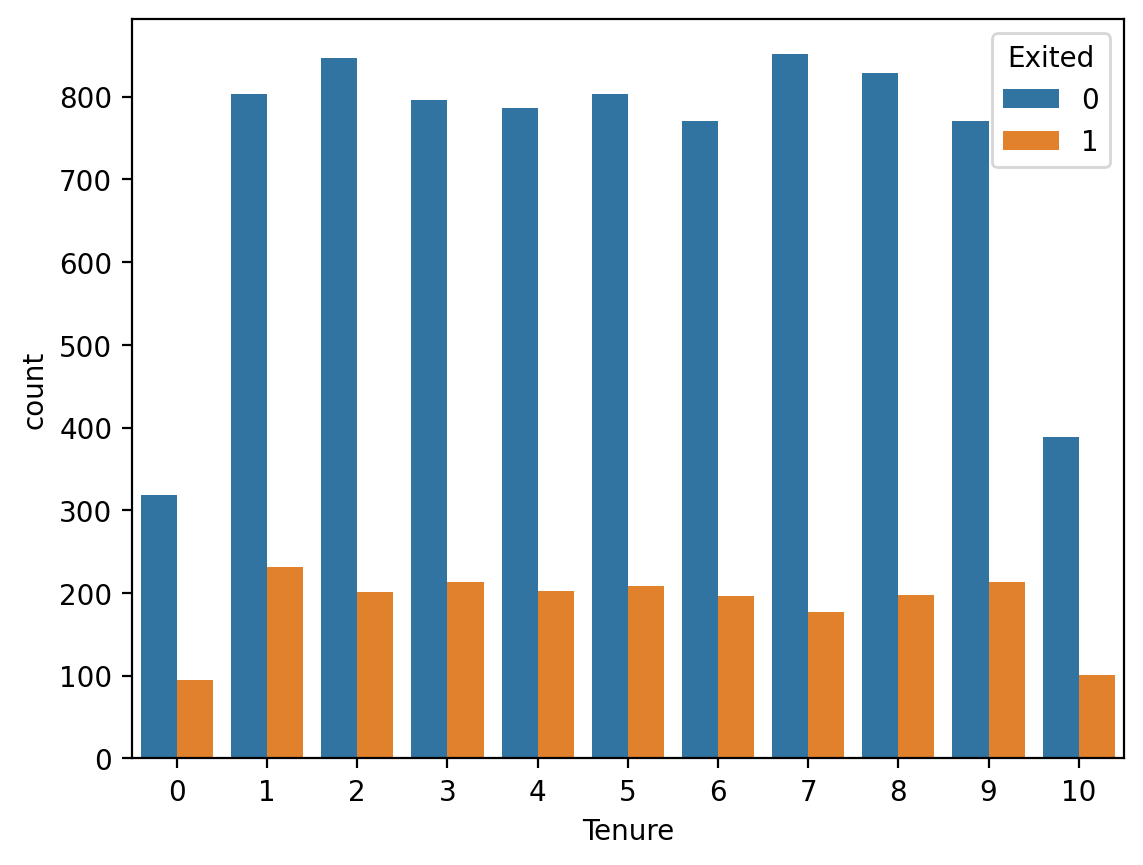

In [22]:
# graph chrun and not chrun rate
sns.countplot(data=df, x="Tenure", hue="Exited")


Above is a graph that shows the churn rate for the categorical feature "Tenure" which is how long a a customer has been a client for the bank.

### NumOfProducts

In [14]:
# Frequency of the not_churn group according to NumOfProducts
not_churn["NumOfProducts"].value_counts().sort_values(ascending=False)

,count
NumOfProducts,
2,4242
1,3675
3,46


In [15]:
# Frequency of
churn["NumOfProducts"].value_counts().sort_values(ascending=False)

,count
NumOfProducts,
1,1409
2,348
3,220
4,60


<Axes: xlabel='NumOfProducts', ylabel='count'>

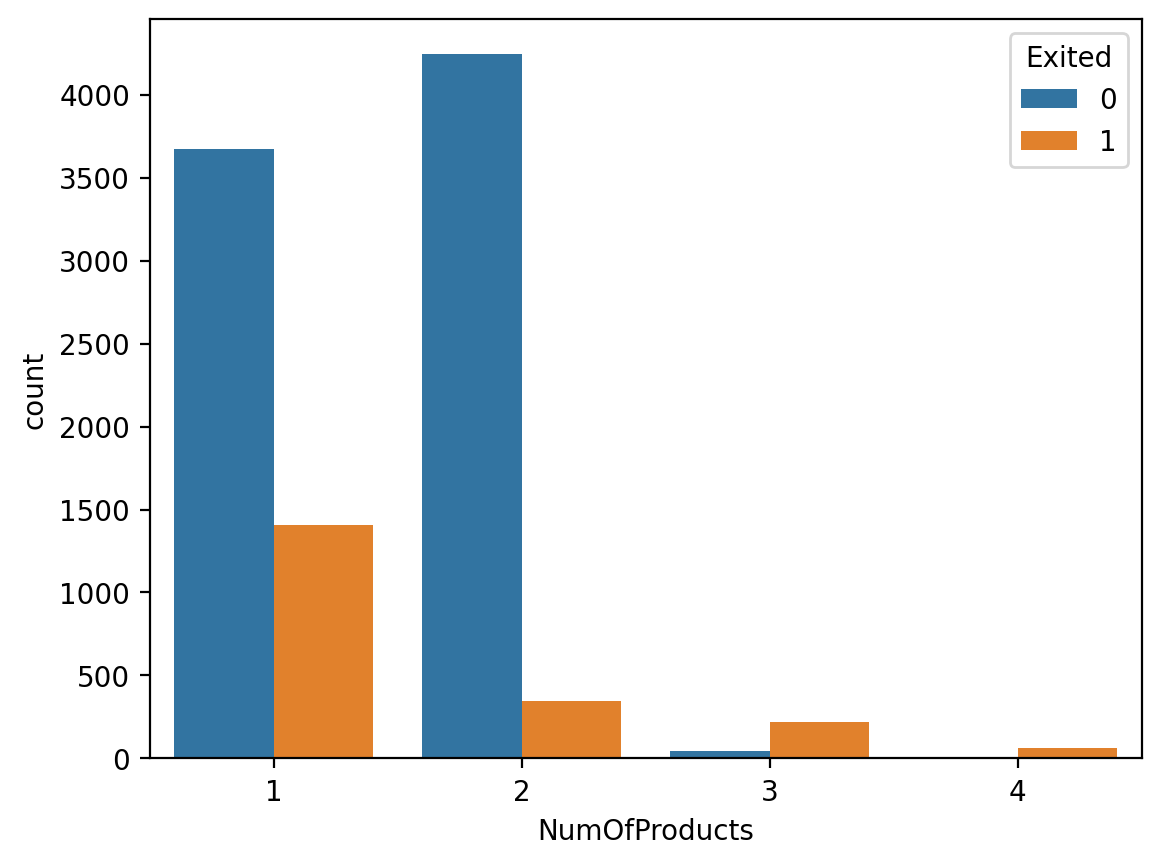

In [16]:
# Graph NumOfProducts
sns.countplot(data=df, x="NumOfProducts", hue="Exited")

### HasCrCard

In [18]:
not_churn["HasCrCard"].value_counts().sort_values(ascending=False)

,count
HasCrCard,
1,5631
0,2332


In [19]:
churn["HasCrCard"].value_counts().sort_values(ascending=False)

,count
HasCrCard,
1,1424
0,613


<Axes: xlabel='HasCrCard', ylabel='count'>

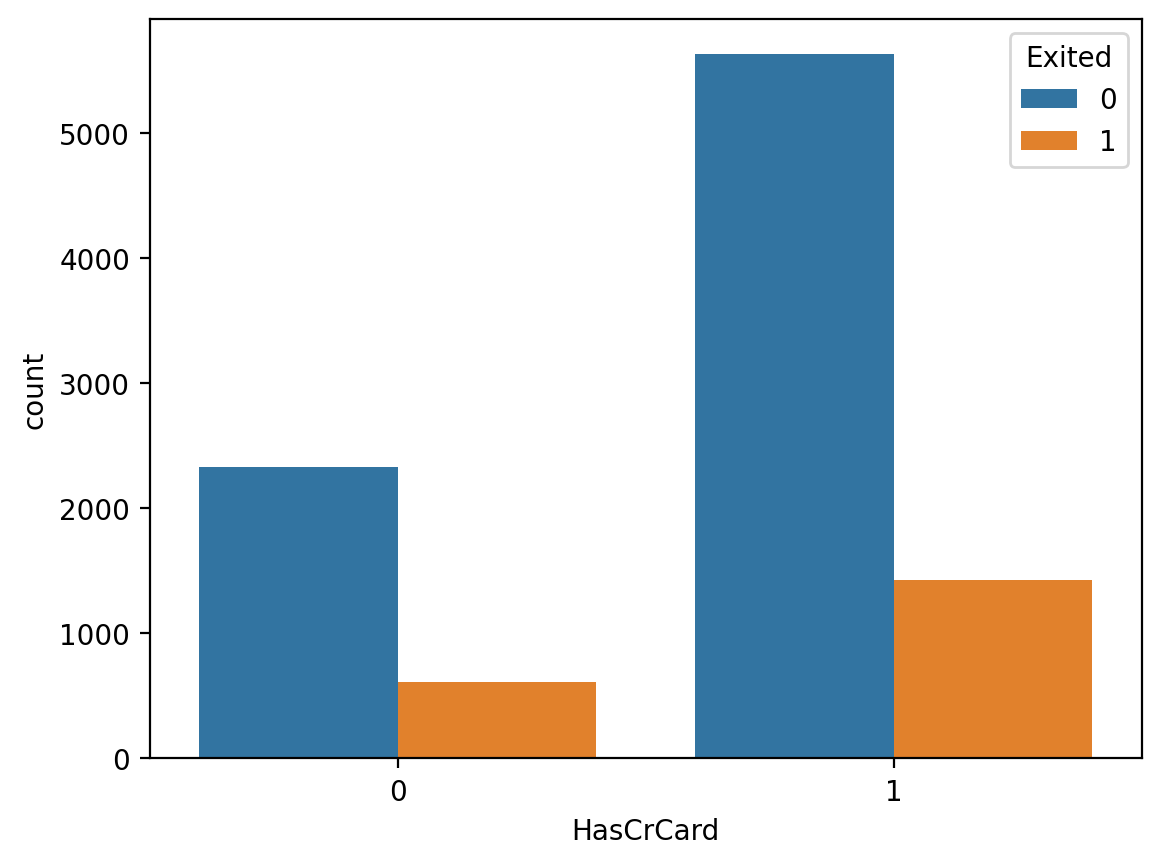

In [20]:
# Plot HasCrCard
sns.countplot(data=df, x="HasCrCard", hue="Exited")

### IsActiveMember

In [21]:
not_churn["IsActiveMember"].value_counts().sort_values(ascending=False)

,count
IsActiveMember,
1,4416
0,3547


In [22]:
churn["IsActiveMember"].value_counts().sort_values(ascending=False)

,count
IsActiveMember,
0,1302
1,735


<Axes: xlabel='IsActiveMember', ylabel='count'>

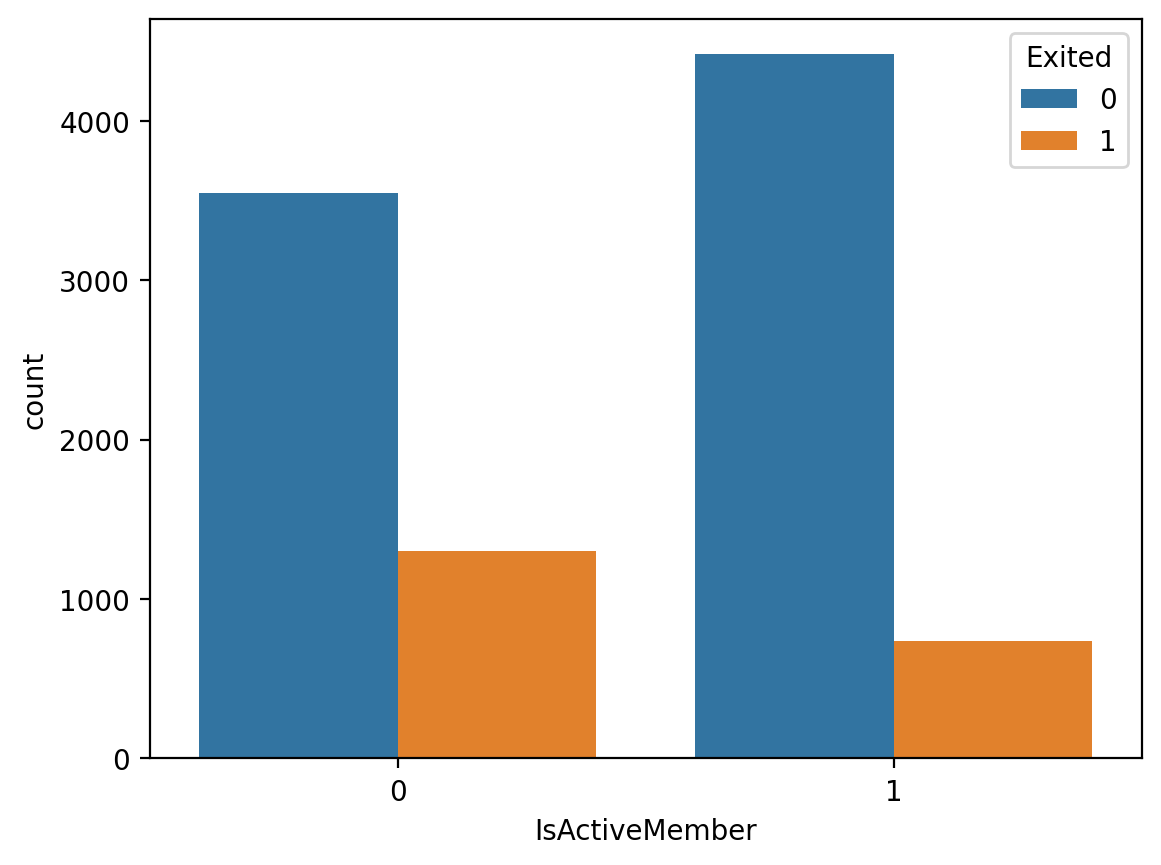

In [23]:
# Graphing "IsActiveMember"
sns.countplot(data=df, x="IsActiveMember", hue="Exited")

### Geogrophay

In [24]:
# Frequency of not_churn group according to "Geogrophay"
not_churn.Geography.value_counts().sort_values(ascending=False)

,count
Geography,
France,4204
Spain,2064
Germany,1695


In [25]:
churn.Geography.value_counts().sort_values(ascending=False)

,count
Geography,
Germany,814
France,810
Spain,413


<Axes: xlabel='Geography', ylabel='count'>

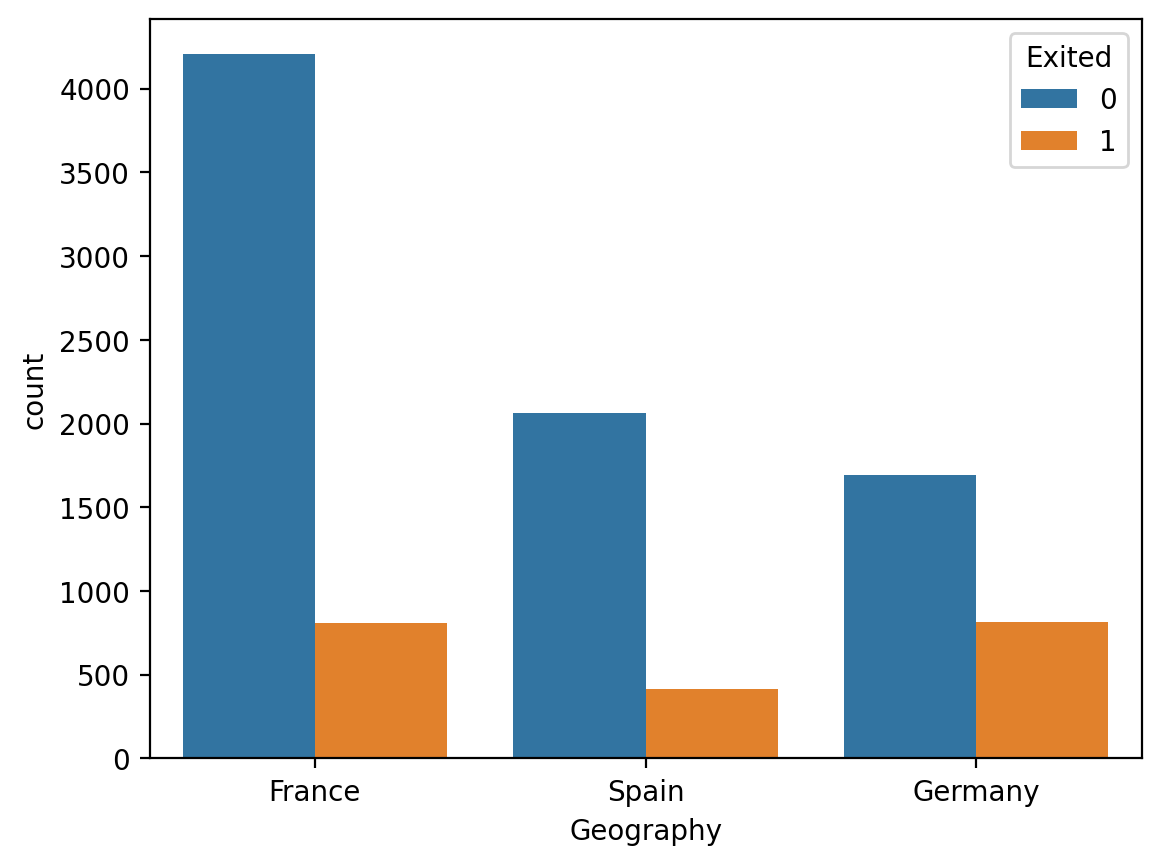

In [26]:
# Graphing "Geography"

sns.countplot(data=df, x="Geography", hue="Exited")

### Gender

In [27]:
# Frequency of not_churn according to Gender
not_churn.Gender.value_counts().sort_values(ascending=False)

,count
Gender,
Male,4559
Female,3404


In [28]:
churn.Gender.value_counts().sort_values(ascending=False)

,count
Gender,
Female,1139
Male,898


<Axes: xlabel='Gender', ylabel='count'>

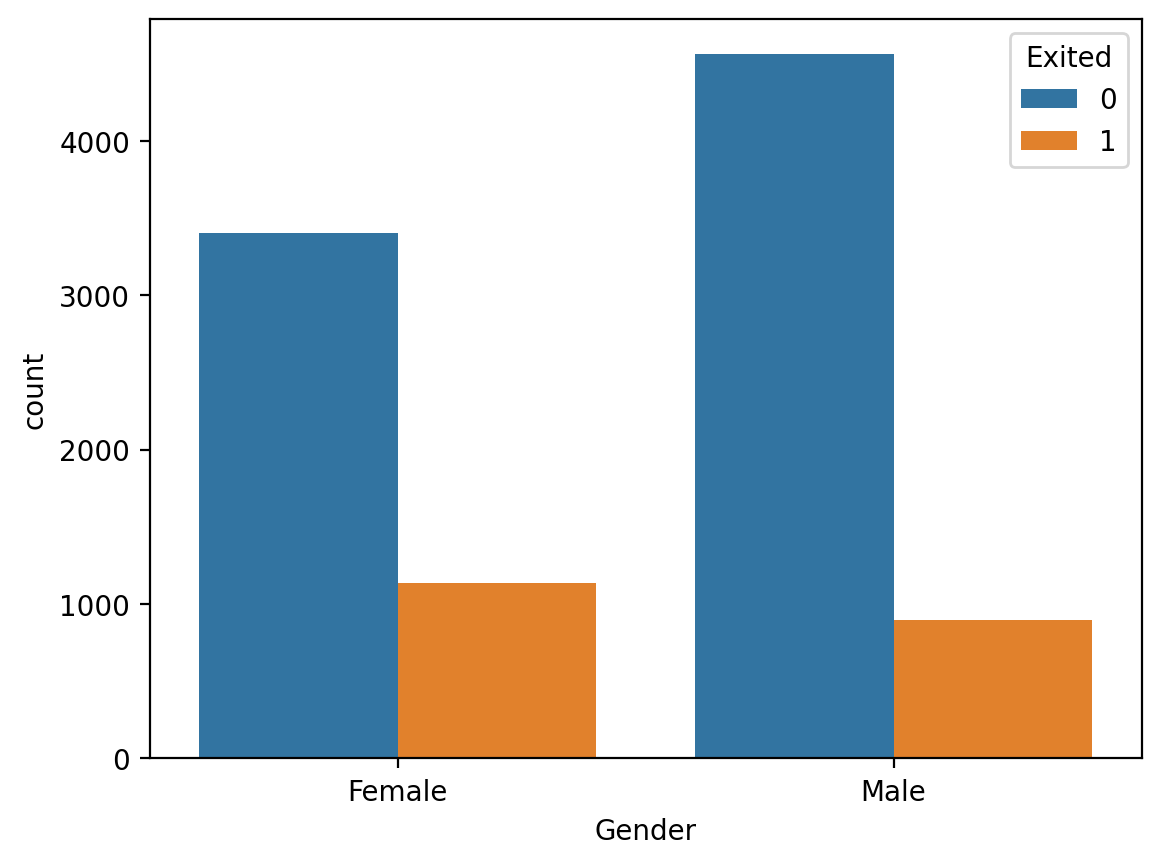

In [29]:
# Graph Gender
sns.countplot(data=df, x="Gender", hue="Exited")

### Numerical Variables

In [30]:
# Examine credit score of the not_churn group
not_churn["CreditScore"].describe()

,CreditScore
count,7963.000000
mean,651.853196
std,95.653837
min,405.000000
25%,585.000000
50%,653.000000
75%,718.000000
max,850.000000


In [31]:
# Examin the credit score for the churn group
churn["CreditScore"].describe()

,CreditScore
count,2037.000000
mean,645.351497
std,100.321503
min,350.000000
25%,578.000000
50%,646.000000
75%,716.000000
max,850.000000


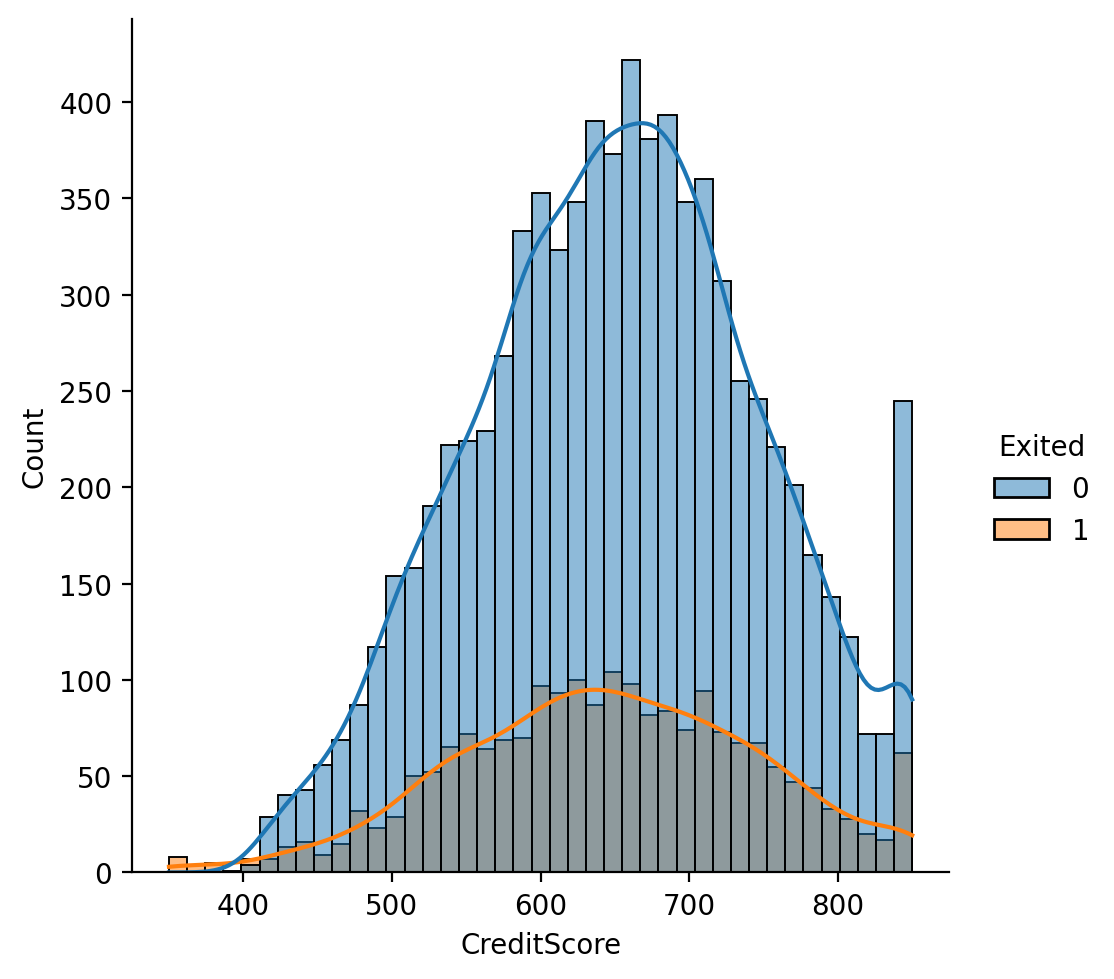

In [33]:
# plotting both churn["CreditScore"] and not_churn["CreditScore"]
sns.displot(data=df, x="CreditScore", hue="Exited", kde=True)

In [34]:
# Examining the age of not_churn group
not_churn["Age"].describe()

,Age
count,7963.000000
mean,37.408389
std,10.125363
min,18.000000
25%,31.000000
50%,36.000000
75%,41.000000
max,92.000000


In [35]:
# Examining the age of chrn of group
churn["Age"].describe()

,Age
count,2037.000000
mean,44.837997
std,9.761562
min,18.000000
25%,38.000000
50%,45.000000
75%,51.000000
max,84.000000


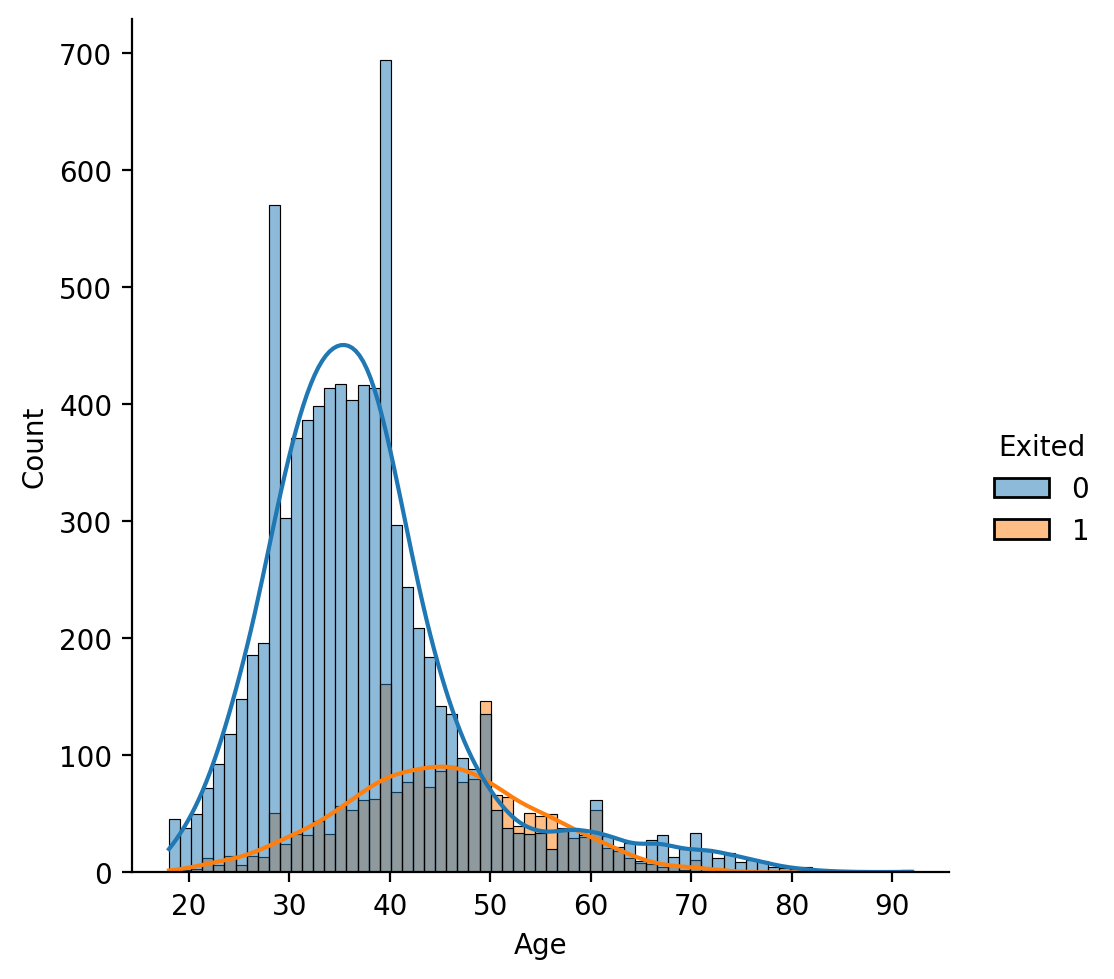

In [36]:
sns.displot(data=df, x="Age", hue="Exited", kde=True)

### Balance

In [37]:
# examin the "Balance" of the not_churn group
not_churn["Balance"].describe()

,Balance
count,7963.000000
mean,72745.296779
std,62848.040701
min,0.000000
25%,0.000000
50%,92072.680000
75%,126410.280000
max,221532.800000


In [38]:
# examin the "Balance" of the churn group
churn["Balance"].describe()

,Balance
count,2037.000000
mean,91108.539337
std,58360.794816
min,0.000000
25%,38340.020000
50%,109349.290000
75%,131433.330000
max,250898.090000


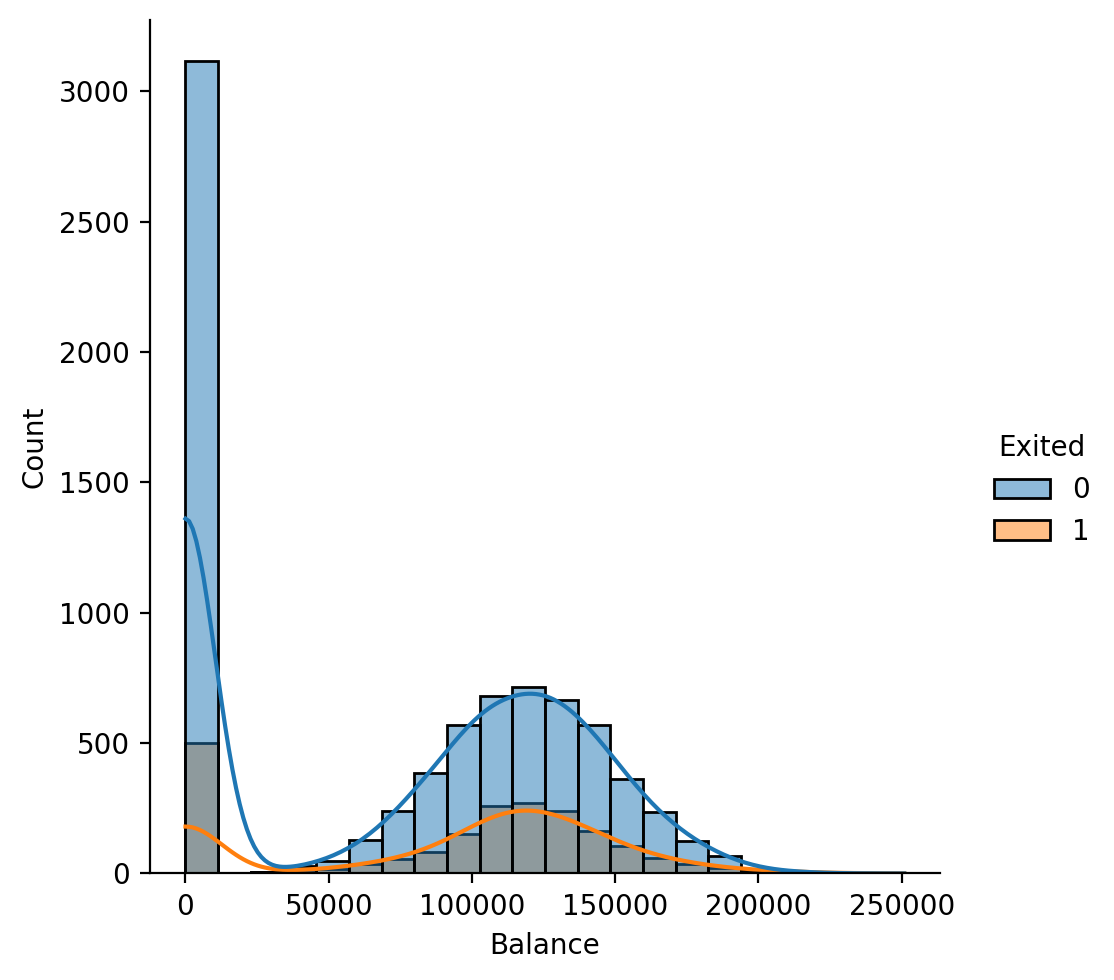

In [39]:
# Plot
sns.displot(data=df, x="Balance", hue="Exited", kde=True)

### EstimatedSalary

In [42]:
not_churn["EstimatedSalary"].describe()

,EstimatedSalary
count,7963.000000
mean,99738.391772
std,57405.586966
min,90.070000
25%,50783.490000
50%,99645.040000
75%,148609.955000
max,199992.480000


In [43]:
churn["EstimatedSalary"].describe()

,EstimatedSalary
count,2037.000000
mean,101465.677531
std,57912.418071
min,11.580000
25%,51907.720000
50%,102460.840000
75%,152422.910000
max,199808.100000


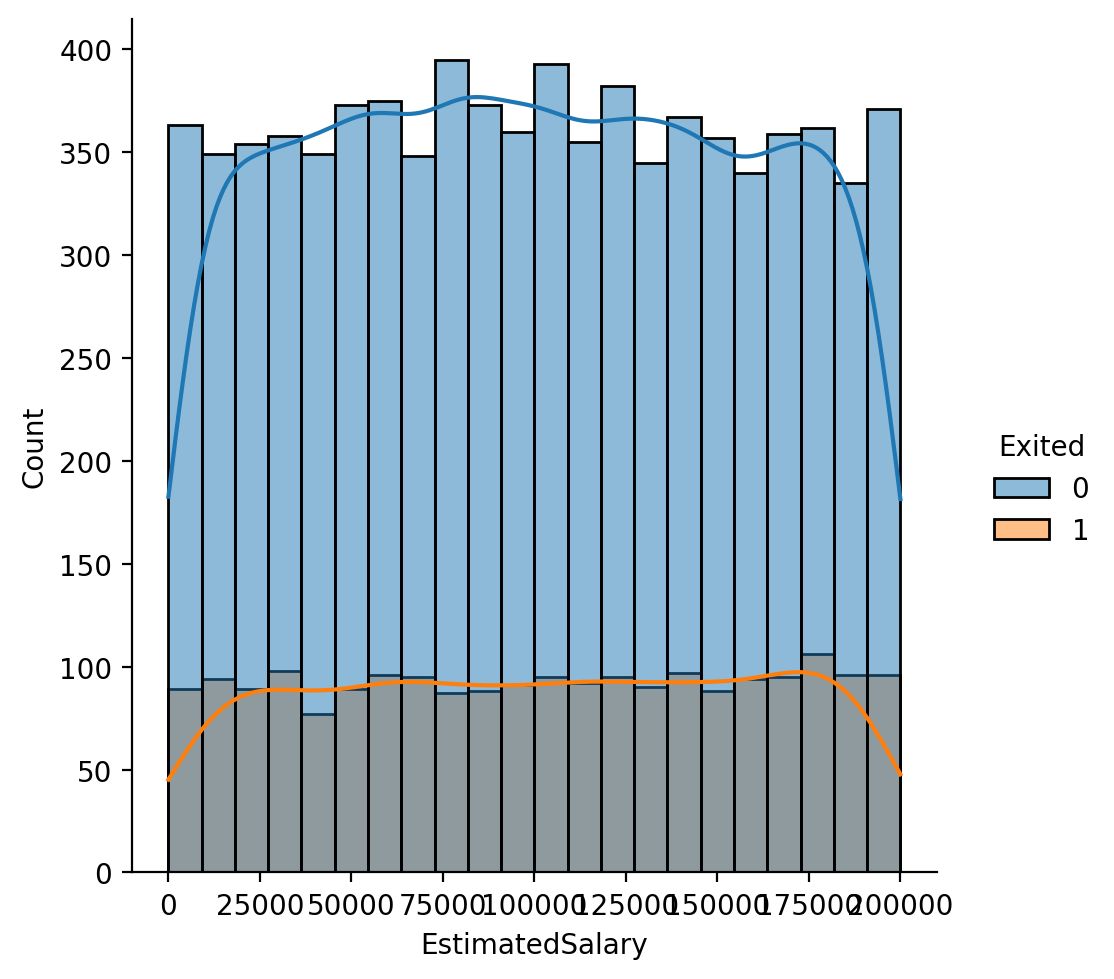

In [45]:
# Plot
sns.displot(data=df, x="EstimatedSalary", hue="Exited", kde=True)

### Correlation Matrix

In [11]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


<Axes: >

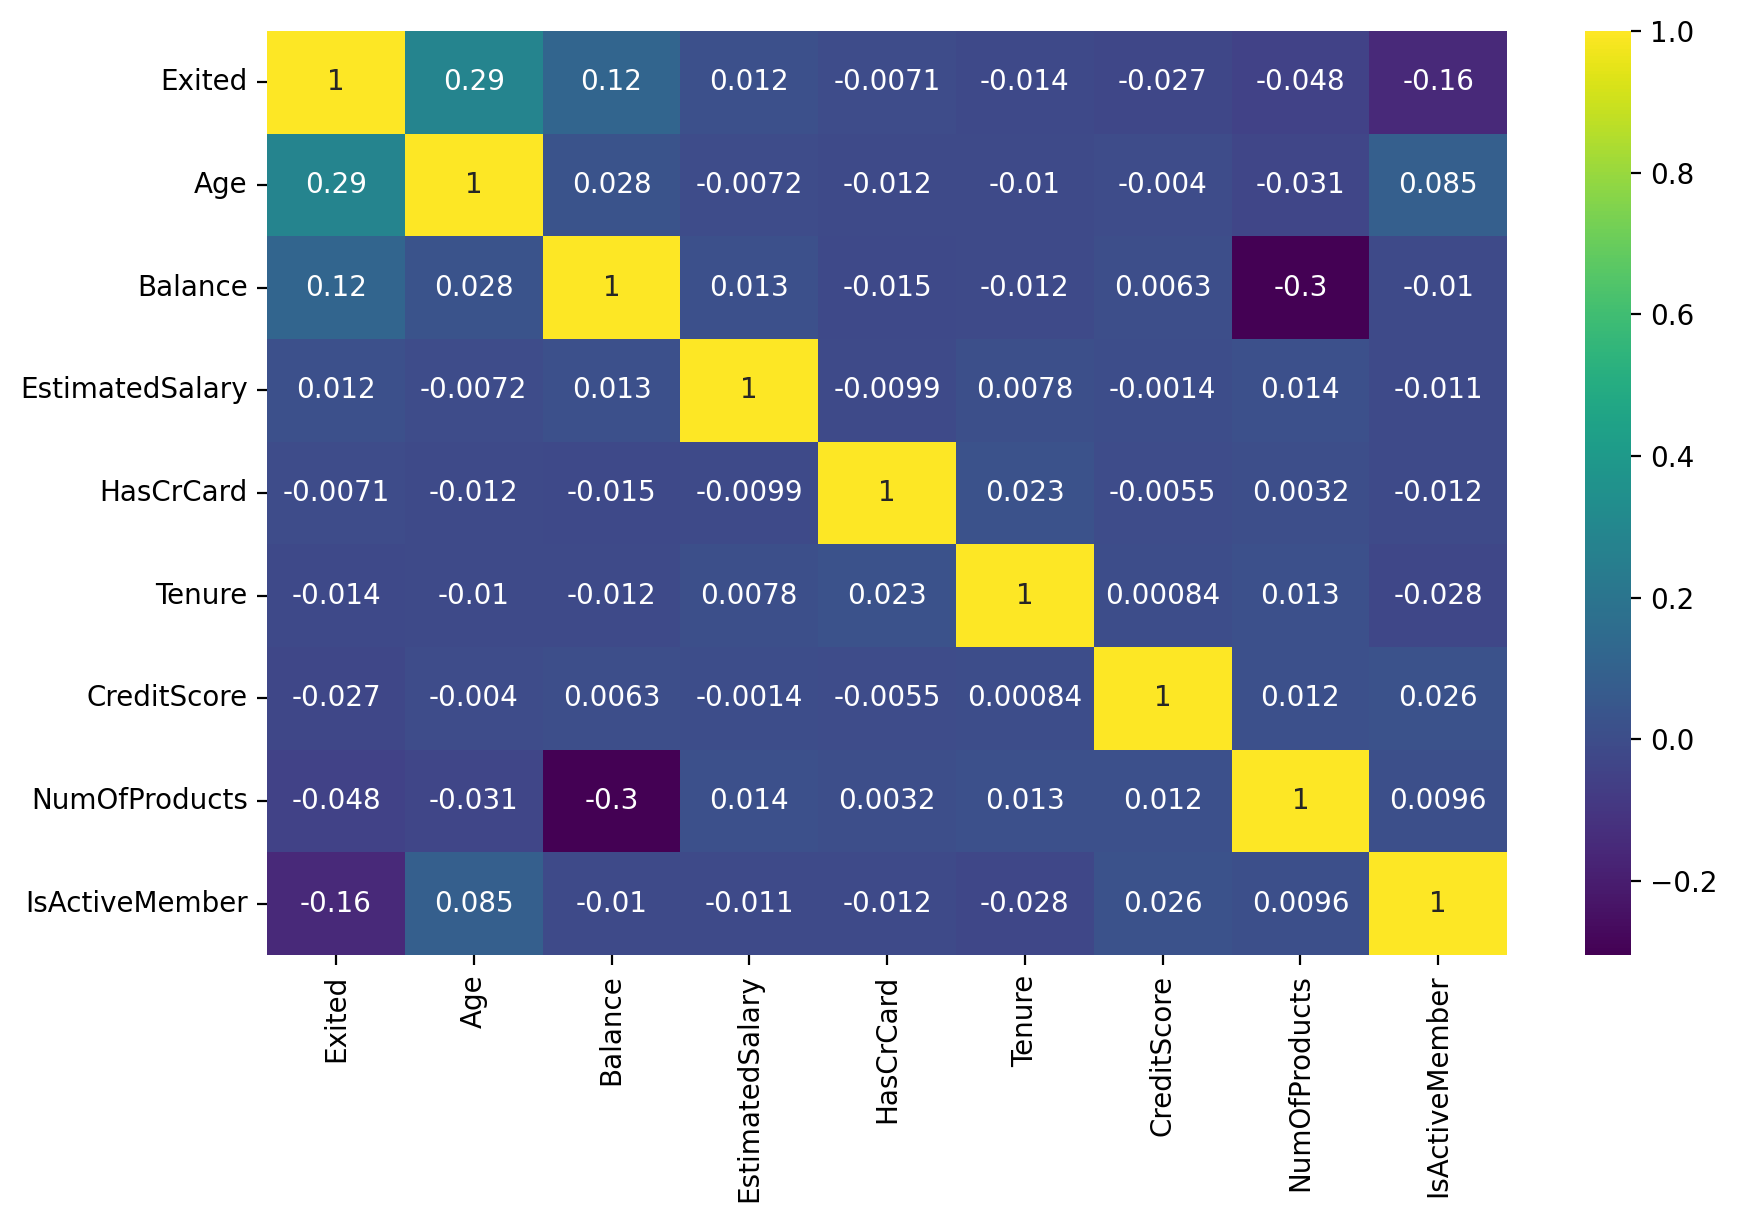

In [53]:
# Correlation Matrix
k = 10
cols = df.corr(numeric_only=True).nlargest(k, 'Exited')['Exited'].index
cm = df[cols].corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

# Data Preprocessing

In [54]:
# Looking for Missing Values
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [10]:
# applying OneHotEncoder
df = pd.get_dummies(df, columns=['Gender', 'Geography'], drop_first=True, dtype=int)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [12]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [13]:
# Standardize CreditScore, Age, Tenure, Balance, EstimatedSalary
std_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
std_scaler = preprocessing.StandardScaler()
df[std_list] = std_scaler.fit_transform(df[std_list])
df.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,-0.326221,0.293517,-1.041760,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,1,0,1,0.216534,0,0,0,1
2,-1.536794,0.293517,1.032908,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,1,1,1,-0.365276,0,0,0,1


In [14]:
# Split the dataset
X = df.drop('Exited', axis=1).values
y = df['Exited'].values

print(X.shape)
print(y.shape)

(10000, 11)
(10000,)


In [15]:
# Seperate into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

In [16]:
models = [('LR', LogisticRegression(random_state=1)),
          ('KNN', KNeighborsClassifier()),
          ('DT', DecisionTreeClassifier(random_state=1)),
          ('RF', RandomForestClassifier(random_state=1)),
          ('SVR', SVC(gamma='auto', random_state=1)),
          ('GB', GradientBoostingClassifier(random_state=1)),
          ('LightGBM', LGBMClassifier(random_state=1))]

results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.810700 (0.012514)
KNN: 0.832900 (0.008938)
DT: 0.790500 (0.011200)
RF: 0.861700 (0.010010)
SVR: 0.856500 (0.009790)
GB: 0.864300 (0.008026)
[LightGBM] [Info] Number of positive: 1826, number of negative: 7174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202889 -> initscore=-1.368336
[LightGBM] [Info] Start training from score -1.368336
[LightGBM] [Info] Number of positive: 1833, number of negative: 7167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

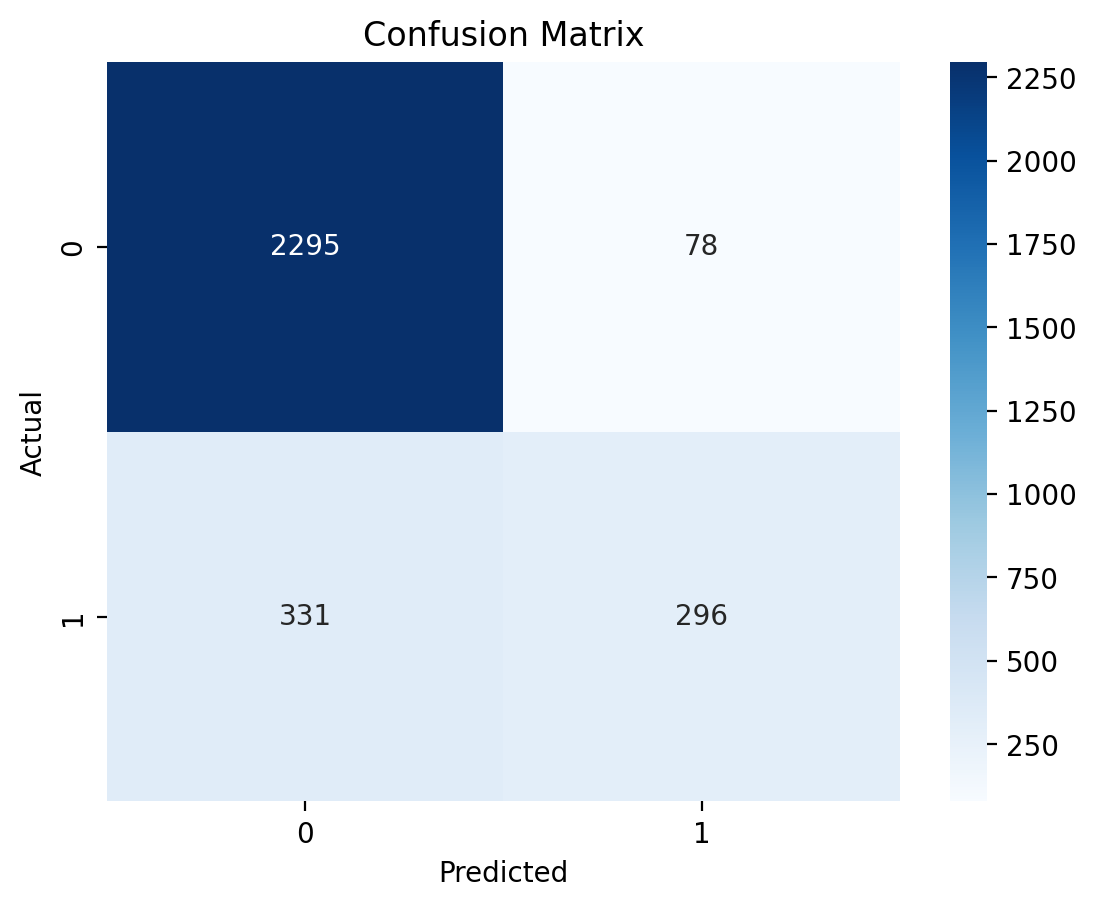

In [17]:
# Gradient Boosting and printing Confusion Matrix
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# print labels of confusion matrix
print("True Positive:", cm[1, 1])
print("True Negative:", cm[0, 0])
print("False Positive:", cm[0, 1])
print("False Negative:", cm[1, 0])

True Positive: 296
True Negative: 2295
False Positive: 78
False Negative: 331


In [19]:
# print classification report for the best model GradientBoost
print(classification_report(gb.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2626
           1       0.47      0.79      0.59       374

    accuracy                           0.86      3000
   macro avg       0.72      0.83      0.75      3000
weighted avg       0.91      0.86      0.88      3000



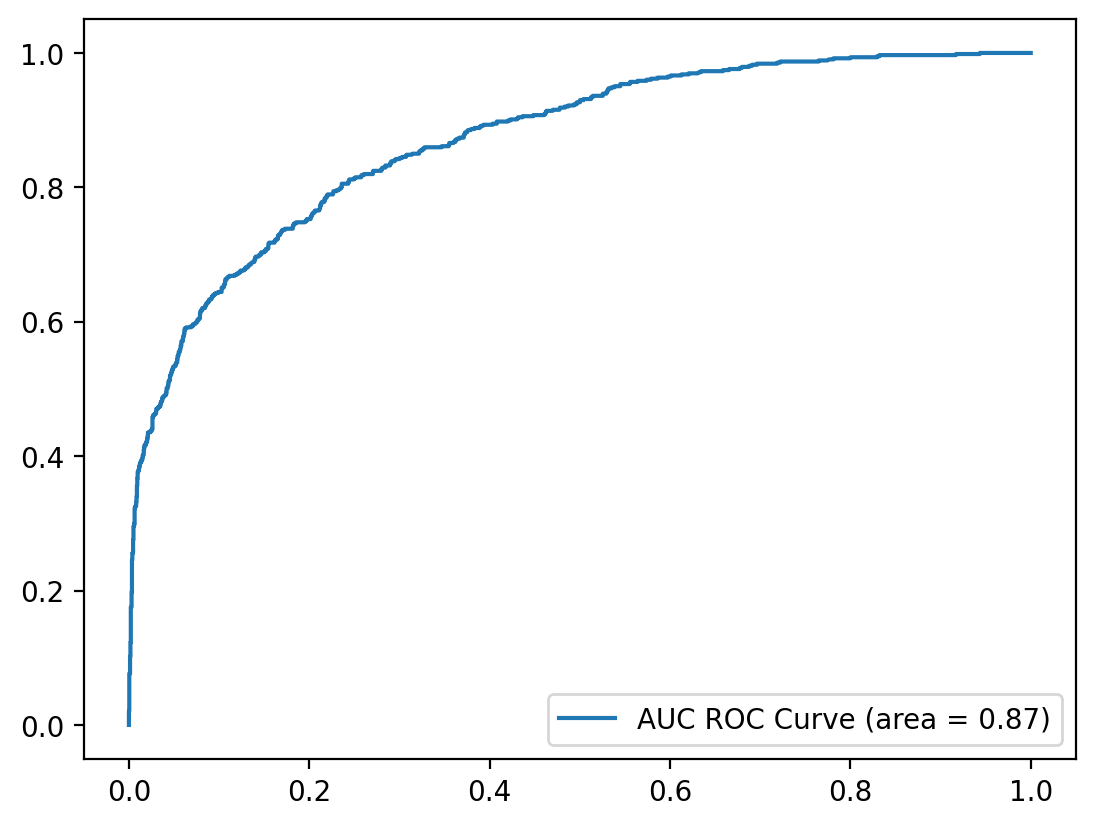

In [20]:
# AUC ROC Curve
def generate_auc_roc_curve(clf, X_test):
  y_pred_proba = gb.predict_proba(X_test)[::,1]
  fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label='AUC ROC Curve (area = %0.2f)' % auc)
  plt.legend(loc=4)
  plt.show()
  pass

generate_auc_roc_curve(gb, X_test)


### Model Tuning

In [21]:
# LightGBM:
lgb_model = LGBMClassifier()

# model tuning
lgbm_params = {'colsample_bytree': 0.5,
               'learning_rate': 0.01,
               'max_depth': 6,
               'n_estimators': 500}

lgbm_tuned = LGBMClassifier(**lgbm_params).fit(X,y)

[LightGBM] [Info] Number of positive: 2037, number of negative: 7963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203700 -> initscore=-1.363328
[LightGBM] [Info] Start training from score -1.363328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [22]:
# Gradient Boosting Model
gbm_model = GradientBoostingClassifier()

# Model Tuning
gbm_params = {'learning_rate': 0.1,
              'max_depth': 3,
              'n_estimators': 200,
              'subsample': 1}

gbm_tuned = GradientBoostingClassifier(**gbm_params).fit(X,y)

In [23]:
# evaluate the model
models = [("LightGBM", lgbm_tuned),
 ("Gradient Boosting", gbm_tuned)]

results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

[LightGBM] [Info] Number of positive: 1826, number of negative: 7174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202889 -> initscore=-1.368336
[LightGBM] [Info] Start training from score -1.368336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Info] Number of positive: 1410, number of negative: 5590
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201429 -> initscore=-1.377390
[LightGBM] [Info] Start training from score -1.377390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

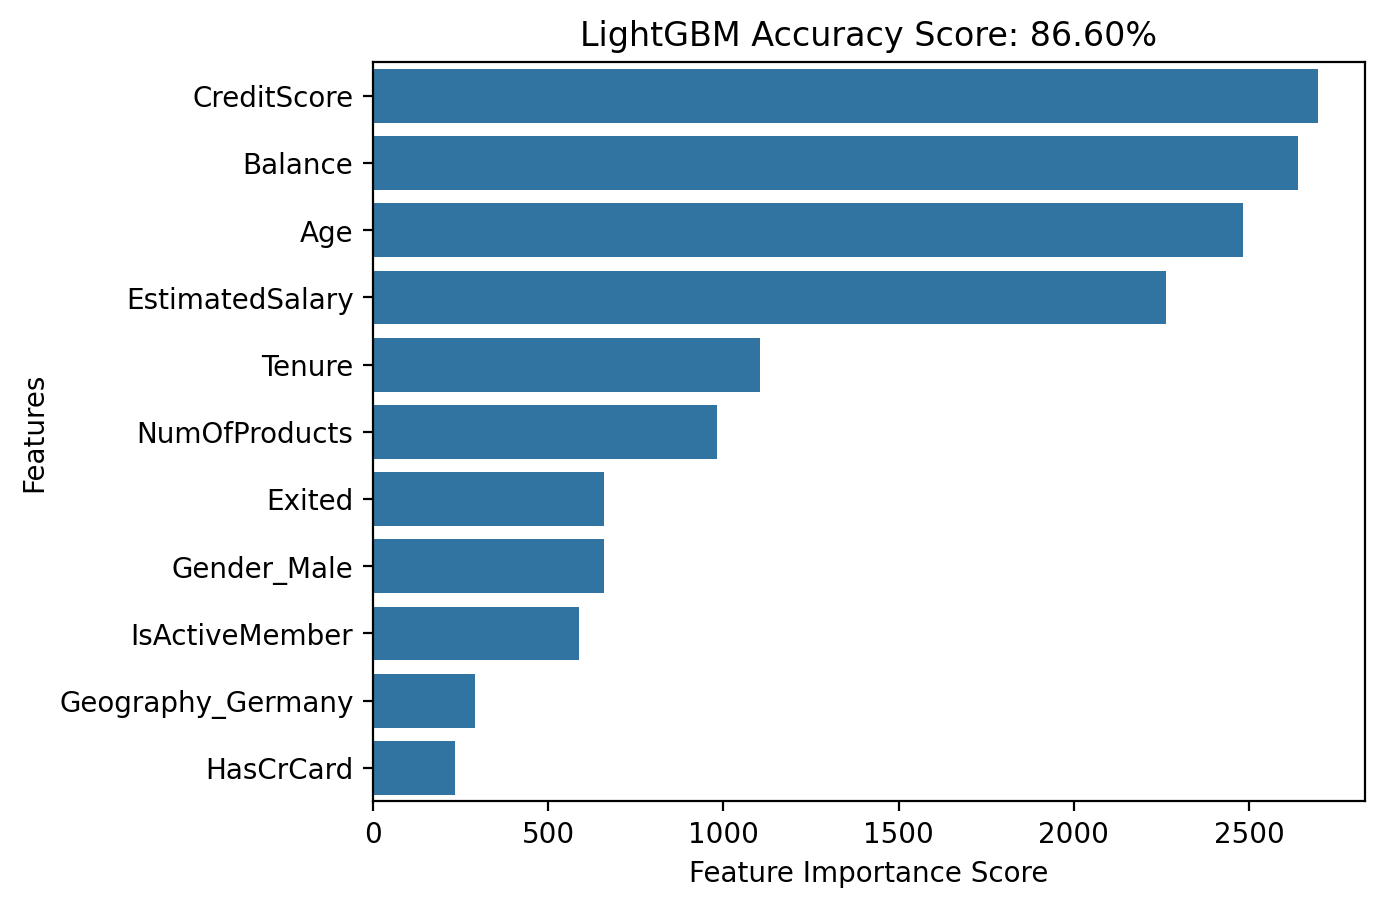

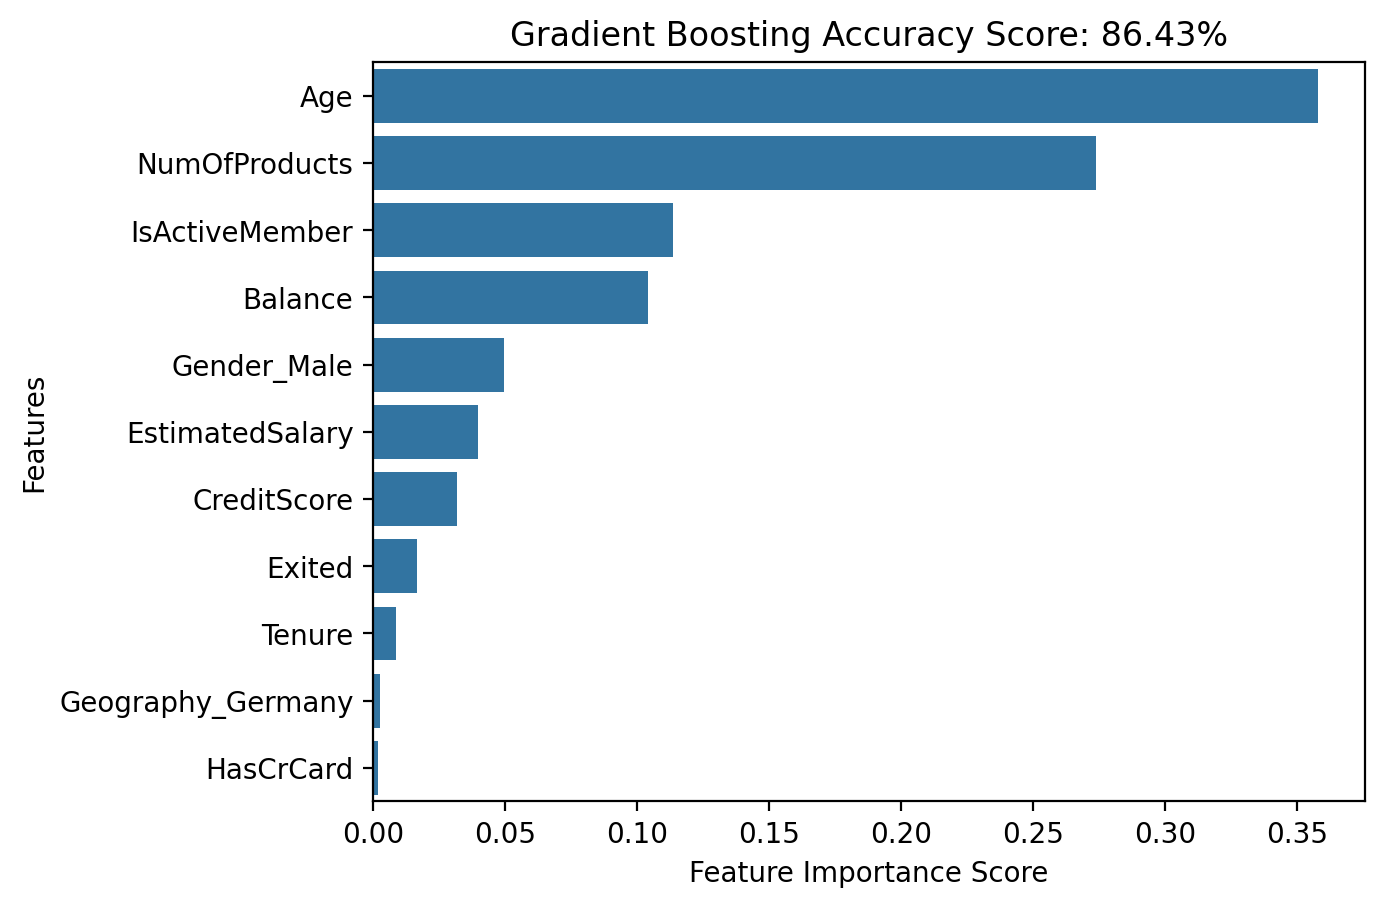

In [24]:
# plotting models
for name, model in models:
  base = model.fit(X_train, y_train)
  y_pred = base.predict(X_test)
  acc_score = accuracy_score(y_test, y_pred)
  feature_imp = pd.Series(base.feature_importances_, index=df.columns[:-1]).sort_values(ascending=False)

  sns.barplot(x=feature_imp, y=feature_imp.index)
  plt.xlabel('Feature Importance Score')
  plt.ylabel('Features')
  plt.title(f"{name} Accuracy Score: {acc_score*100:.2f}%")
  plt.show()

### Reults and Conclusion
Conclusion:

The goal of this model is to make predictions to determine if a client will leave leave and close their account at the bank. The dataset contained 1000 rows and 10 features. During the preprocessing stage I needed to deal with the categorial data that which was simple enough. Then, I needed to standardize the columns such as Age, CreditScore and Balance to name a few features. Once that was completed I was able to run it through several models to determine which models would work best for this dataset.

Results:

The models that performed well for this dataset is the GradientBoost and LightGBM they both showed 86% accuracy in determining if a client will leave the bank. After fine tuning the model the accurcy did not improve much. Finally, I graphed the feature importance for each model. The one feature that is important to both models is Age of the customer. The second feature that was in the top 4 for both models was Balance of the account.